In [14]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import os
import h5py
import os
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec


plt.style.use('seaborn-v0_8-darkgrid')


In [15]:
TITLE_SIZE = 18
TITLE_PAD = 15
LABEL_SIZE = 14
LEGEND_SIZE = 16
FIG_X_SIZE = 10
FIG_Y_SIZE = 6
PLOT_WIDTH = 2
TICK_SIZE = 12


GRAY_LINE_COLOR = "#777777"

MAIN_LINE_COLOR = "#005f73"
MAIN_FILL_COLOR = "#2aad8f"

SECOND_LINE_COLOR = "#1b3240"
SECOND_FILL_COLOR = "#264653"

THIRTH_LINE_COLOR = "#b89e3c"
THIRTH_FILL_COLOR = "#e9c46a"

FOURTH_LINE_COLOR = "#b34a3d"
FOURTH_FILL_COLOR = "#e76f51"


RED_LINE_COLOR = '#6a0000'
RED_FILL_COLOR = '#f9a6a6'

BLUE_LINE_COLOR = '#003d4d'
BLUE_FILL_COLOR = '#a6dee3'

GREEN_LINE_COLOR = '#093e00'
GREEN_FILL_COLOR = '#81d784'

### Importação dos dados

In [16]:
class Load_Data:
    def __init__(self,file,var_name,n_data_in_file):
        self.path = file
        self.var_name = var_name
        self.n_data_in_file = n_data_in_file
        self.loadData()



    def loadData(self):
        self.episodic_data = []
        with h5py.File(self.path, 'r') as f:
            total_datasets = len(f.keys())
            for i in range(int(total_datasets / self.n_data_in_file)):
                episodic_data = f[f"{self.var_name}{i+1}"]
                if self.var_name == "loss_" and i < 2100:
                    mse_data = np.array(f[f"mse_{i+1}"])
                    corrected_data = episodic_data - 0.5 * mse_data
                    self.episodic_data.append(corrected_data)
                else:
                    self.episodic_data.append(np.array(episodic_data))
    
    def get_maxs_list(self):
        return np.array([data.max() for data in self.episodic_data])
    def get_mins_list(self):
        return np.array([data.min() for data in self.episodic_data])
    def get_mean_list(self):
        return np.array([data.mean() for data in self.episodic_data])
    def get_sum_list(self):
        return np.array([data.sum() for data in self.episodic_data])
    def get_std_deviation_step(self):
        return np.array([np.std(data) for data in self.episodic_data])

    def get_moving_mean_sum_episode(self,window):
        return np.convolve(self.get_sum_list(), np.ones(window)/window, mode='valid')
    def get_moving_mean_episode(self,window):
        return np.convolve(self.episodic_data, np.ones(window)/window, mode='valid')
    def get_std_deviation_episode(self,window):
        return [np.std(self.episodic_data[i:i+window]) for i in range(len(self.episodic_data) - window + 1)]
    def get_std_deviation_sum_episode(self,window):
        return [np.std(self.get_sum_list()[i:i+window]) for i in range(len(self.episodic_data) - window + 1)]



In [17]:
datafolder = "models"

x =                 Load_Data(f"/home/victor/tg_proj/{datafolder}/Positions.h5","x_",3)
y =                 Load_Data(f"/home/victor/tg_proj/{datafolder}/Positions.h5","y_",3)
z =                 Load_Data(f"/home/victor/tg_proj/{datafolder}/Positions.h5","z_",3)

rewards =           Load_Data(f"/home/victor/tg_proj/{datafolder}/Misc.h5","reward_",4)
# rewards2 =          Load_Data(f"/home/victor/tg_proj/{datafolder}/Misc2.h5","reward_",4)
cg_inside =         Load_Data(f"/home/victor/tg_proj/{datafolder}/Misc.h5","y_",4)
poligon_area =      Load_Data(f"/home/victor/tg_proj/{datafolder}/Misc.h5","x_",4)
correct_direction = Load_Data(f"/home/victor/tg_proj/{datafolder}/Misc.h5","x_",4)

end_cause =         Load_Data(f"/home/victor/tg_proj/{datafolder}/EndCause.h5","info_",1)

vx =                Load_Data(f"/home/victor/tg_proj/{datafolder}/Speeds.h5","vx_",3)
vy =                Load_Data(f"/home/victor/tg_proj/{datafolder}/Speeds.h5","vy_",3)
vz =                Load_Data(f"/home/victor/tg_proj/{datafolder}/Speeds.h5","vz_",3)

roll =              Load_Data(f"/home/victor/tg_proj/{datafolder}/RPY.h5","roll_",3)
pitch =             Load_Data(f"/home/victor/tg_proj/{datafolder}/RPY.h5","pitch_",3)
yaw =               Load_Data(f"/home/victor/tg_proj/{datafolder}/RPY.h5","yaw_",3)


function_loss =     Load_Data(f"/home/victor/tg_proj/{datafolder}/Losses.h5","loss_",2)
mse =               Load_Data(f"/home/victor/tg_proj/{datafolder}/Losses.h5","mse_",2)

2203


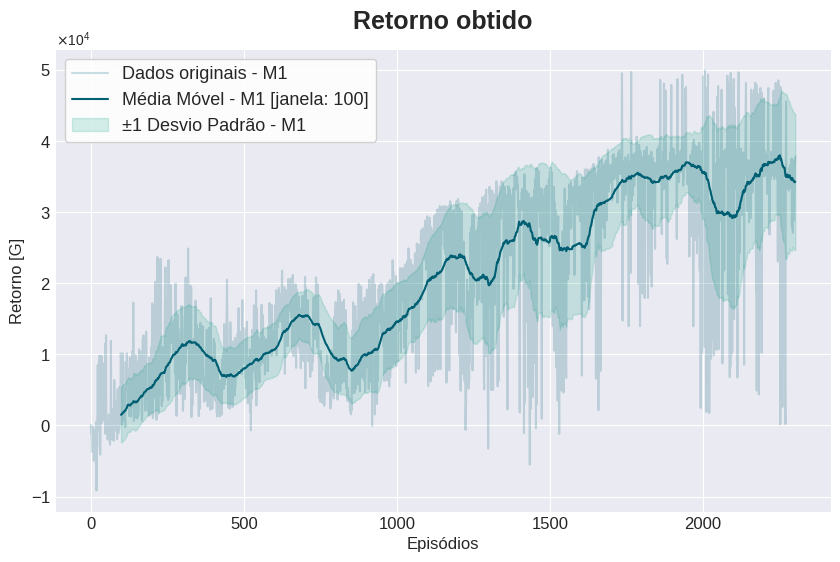

In [18]:
window =100
print(len(rewards.get_std_deviation_sum_episode(window)))

fig, ax = plt.subplots(figsize=(FIG_X_SIZE, FIG_Y_SIZE))
ax.plot(rewards.get_sum_list(), label='Dados originais - M1',color = MAIN_LINE_COLOR, alpha=0.2)
# ax.plot(rewards2.get_sum_list(), label='Dados originais - M2',color = SECOND_LINE_COLOR, alpha=0.2)

ax.plot(range(window-1, len(rewards.get_sum_list())), rewards.get_moving_mean_sum_episode(window), label=f'Média Móvel - M1 [janela: {window}]', color=MAIN_LINE_COLOR)
# ax.plot(range(window-1, len(rewards2.get_sum_list())), rewards2.get_moving_mean_sum_episode(window), label=f'Média Móvel - M2 [janela: {window}]', color=SECOND_LINE_COLOR)
ax.fill_between(range(window-1, len(rewards.get_sum_list())), rewards.get_moving_mean_sum_episode(window) - rewards.get_std_deviation_sum_episode(window), rewards.get_moving_mean_sum_episode(window) + rewards.get_std_deviation_sum_episode(window),
                 color=MAIN_FILL_COLOR, alpha=0.2, label='±1 Desvio Padrão - M1')
# ax.fill_between(range(window-1, len(rewards2.get_sum_list())), rewards2.get_moving_mean_sum_episode(window) - rewards2.get_std_deviation_sum_episode(window), rewards2.get_moving_mean_sum_episode(window) + rewards2.get_std_deviation_sum_episode(window),
                #  color=SECOND_FILL_COLOR, alpha=0.2, label='±1 Desvio Padrão - M2')



ax.legend(loc='upper left', fontsize=LEGEND_SIZE-3, frameon=True, framealpha=0.9, facecolor='white')

ax.set_title('Retorno obtido',fontweight='bold', fontsize = TITLE_SIZE, pad=TITLE_PAD)
ax.set_xlabel('Episódios',fontsize = 12)
ax.set_ylabel('Retorno [G]',fontsize =12)
ax.tick_params(axis='both', labelsize=12)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(True)

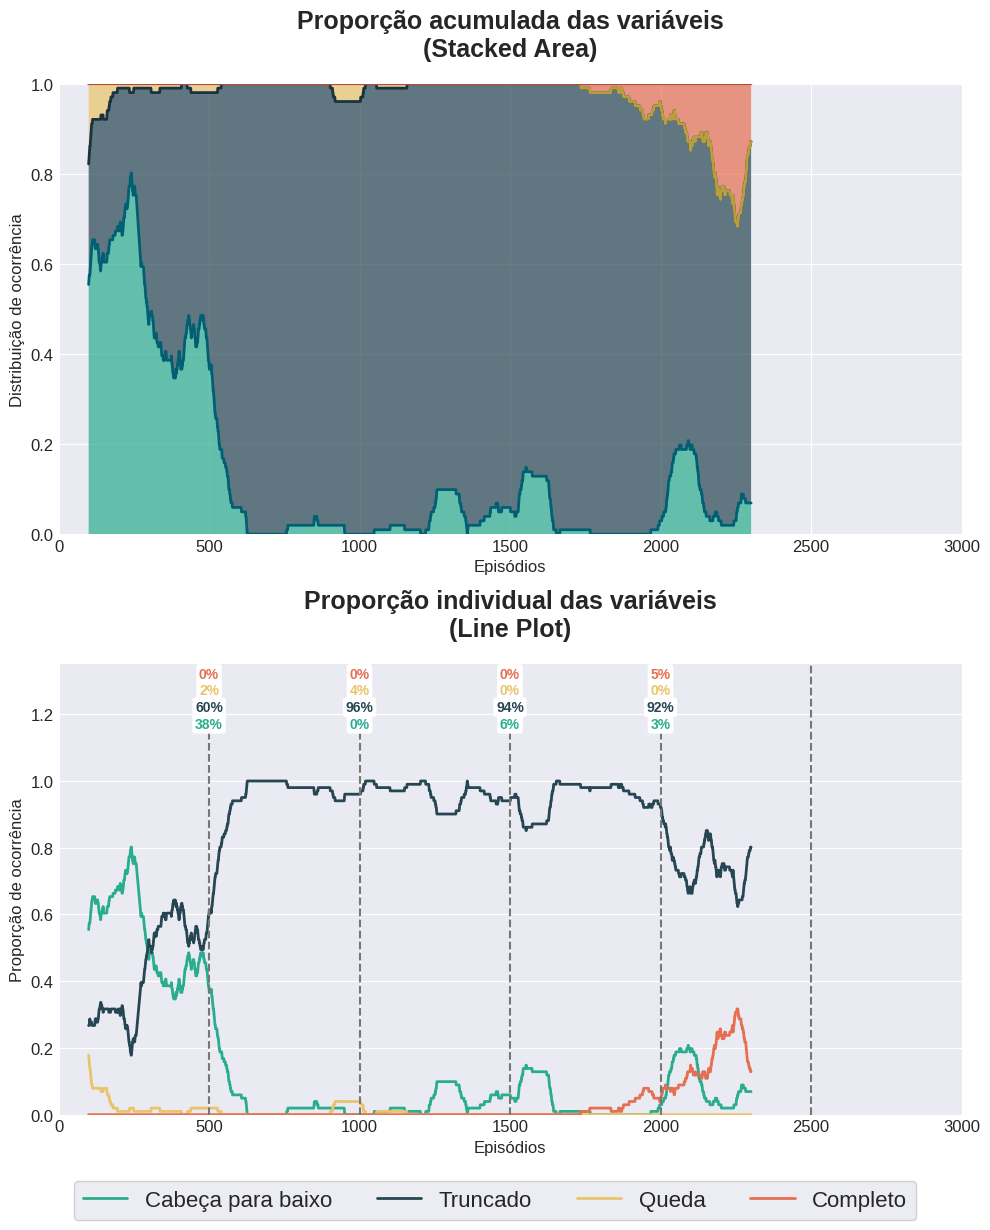

In [19]:

data = end_cause.episodic_data
data = np.array([o.item().decode("utf-8") for o in data])
data_series = pd.Series(data)
df = pd.DataFrame([
    data_series[i-100:i+1].value_counts() for i in range(len(data))
]).fillna(0).astype(int)

proporcoes = df.div(df.sum(axis=1), axis=0)
cores_fill = [
    MAIN_FILL_COLOR, SECOND_FILL_COLOR, THIRTH_FILL_COLOR, FOURTH_FILL_COLOR
]
cores_contorno = [
    MAIN_LINE_COLOR, SECOND_LINE_COLOR, THIRTH_LINE_COLOR, FOURTH_LINE_COLOR
]

proporcoes = proporcoes.reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE*2))

# --- Gráfico 1: Stackplot ---
ax1.stackplot(proporcoes.index, proporcoes.T,
              labels=proporcoes.columns,
              colors=cores_fill, alpha=0.7)

cumulativas = proporcoes.cumsum(axis=1)
for i in range(len(proporcoes.columns)):
    ax1.plot(proporcoes.index, cumulativas.iloc[:, i],
             color=cores_contorno[i], linewidth=2)

ax1.set_title('Proporção acumulada das variáveis\n(Stacked Area)',
              fontsize=TITLE_SIZE, fontweight='bold', pad=20)
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 3000])
ax1.set_xlabel('Episódios', fontsize=12)
ax1.set_ylabel('Distribuição de ocorrência', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)

# --- Gráfico 2: Linhas individuais + porcentagens a cada 500 episódios ---
# Plotar as linhas normais
for i, col in enumerate(proporcoes.columns):
    y = proporcoes[col]
    cor = cores_fill[i]
    ax2.plot(proporcoes.index, y, label=col, color=cor, linewidth=2)

# Alturas fixas pra cada categoria (você pode ajustar se quiser)
y_text_positions = [1.15, 1.20, 1.25, 1.30]

# Colocar os textos a cada 500 episódios, em alturas separadas
for i, col in enumerate(proporcoes.columns):
    cor = cores_fill[i]
    y_text_pos = y_text_positions[i]
    y = proporcoes[col]
    for idx in range(0, len(proporcoes), 500):
        valor = y.iloc[idx]
        txt = f'{valor:.0%}'
        if idx != 0:
            ax2.text(idx, y_text_pos, txt, color=cor, fontsize=10, fontweight='bold',
                    ha='center', va='bottom',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))
ax2.set_title('Proporção individual das variáveis\n(Line Plot)',
              fontsize=TITLE_SIZE, fontweight='bold', pad=20)
ax2.set_xlim([0, 3000])
ax2.set_xlabel('Episódios', fontsize=12)
ax2.set_ylabel('Proporção de ocorrência', fontsize=12)
ax2.tick_params(axis='both', labelsize=12)
# Ajustar limite do eixo y pra dar espaço pras anotações
ax2.set_ylim(0, 1.35)
labels = ["Cabeça para baixo", "Truncado", "Queda", "Completo"]
handles, _ = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=LEGEND_SIZE,
           frameon=True, framealpha=0.9, bbox_to_anchor=(0.5, 0))
ax2.vlines([500 * i for i in range(1,int(3000/500))],ymin = 0, ymax = 2,colors=GRAY_LINE_COLOR, linestyle='--',linewidth = 1.5)

plt.tight_layout(rect=[0, 0, 1, 0.98])

### Análise de posições

AttributeError: 'Series' object has no attribute 'episodic_data'

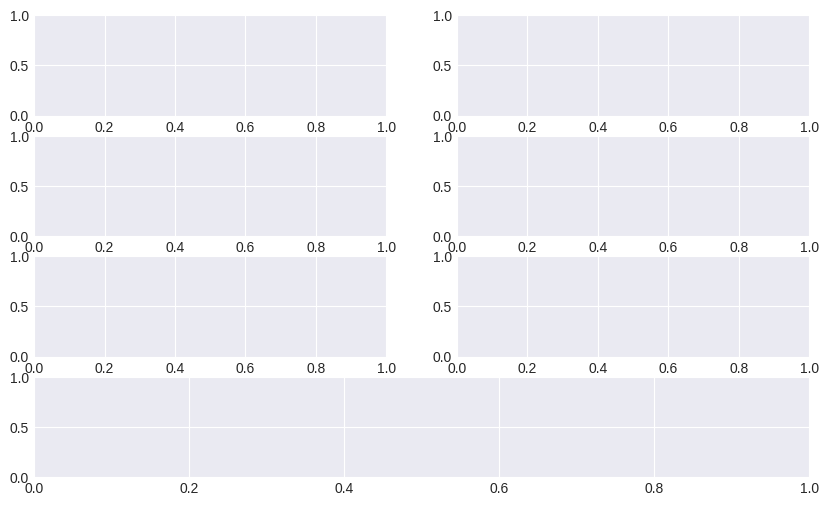

In [20]:
GAP = 400
NCOLS = 2
NROWS = 4


vmin = 0
vmax = 0.09

def plot_heatmap(x, y, ax,vmin,vmax):    
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)

    # Limites fixos
    xmin, xmax = -30, 0
    ymin, ymax = -2.5, 2.5

    # Criação de uma grade para avaliar a densidade
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = kde(positions).reshape(xx.shape)

    contour = ax.contourf(xx, yy, f, levels=100, cmap='jet',vmin=vmin,vmax=vmax)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    return contour


fig = plt.figure(figsize=(FIG_X_SIZE, FIG_Y_SIZE))
gs = gridspec.GridSpec(NROWS, NCOLS, figure=fig)

axes = []
# Criar 6 eixos normais
for row in range(NROWS - 1):
    for col in range(NCOLS):
        axes.append(fig.add_subplot(gs[row, col]))

# Último eixo ocupa as duas colunas da última linha
axes.append(fig.add_subplot(gs[NROWS - 1, :]))

plot_index = 0
x_buffer = []
y_buffer = []

for i in range(int(len(x.episodic_data))):
    x_buffer.extend(x.episodic_data[i])
    y_buffer.extend(y.episodic_data[i])
    if i % GAP == 0 and i != 0:
        if plot_index < len(axes)-1:
            ax = axes[plot_index]
            contour = plot_heatmap(x_buffer, y_buffer, ax, vmin=vmin, vmax=vmax)
            start = plot_index * GAP
            end = (plot_index + 1) * GAP if plot_index != len(axes) else len(x.episodic_data)
            ax.set_title(f'Episódios: {start} - {end}', fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            plot_index += 1
            contour_for_cbar = contour
            x_buffer.clear()
            y_buffer.clear()
ax = axes[plot_index]
contour = plot_heatmap(x_buffer, y_buffer, ax,vmin=vmin,vmax=vmax)
start = plot_index * GAP
end =  len(x.episodic_data)-2
ax.set_title(f'Episódios: {start} - {end}', fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
contour_for_cbar = contour
x_buffer.clear()
y_buffer.clear()

    


fig.suptitle('Mapas de Posições', fontsize=18, fontweight='bold')

# Barra de cor
if contour_for_cbar:
    cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(contour_for_cbar, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()


In [21]:
print(y)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2297    0.138614
2298    0.138614
2299    0.128713
2300    0.128713
2301    0.128713
Name: arrival, Length: 2302, dtype: float64


### Função de perda

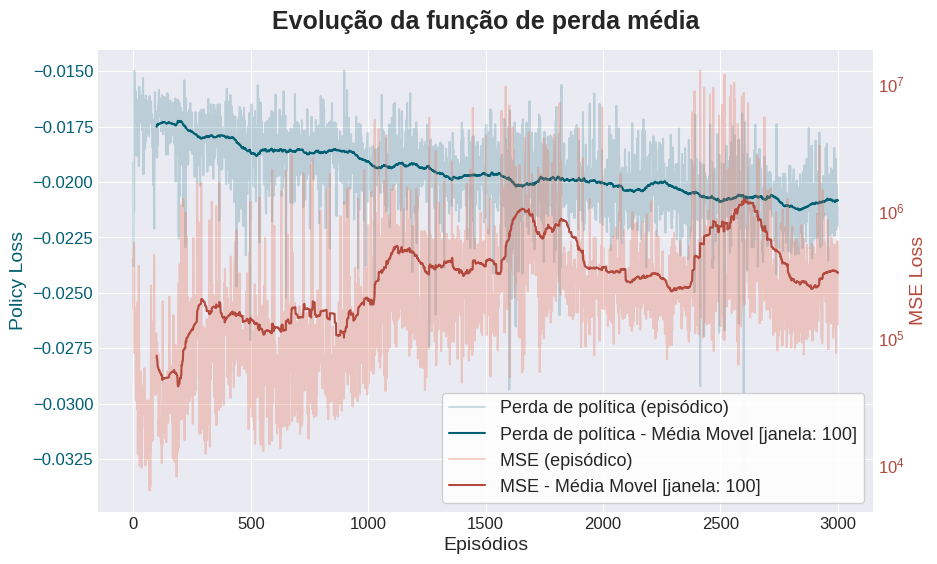

In [159]:
window = 100
fig, ax = plt.subplots(figsize=(FIG_X_SIZE, FIG_Y_SIZE))
steps = range(len(function_loss.get_mean_list()))
ax2 = ax.twinx()

# Curva principal (Policy Loss)
ax.plot(steps, function_loss.episodic_data, label='Perda de política (episódico)', color=MAIN_LINE_COLOR, alpha=0.2)
ax.plot(steps[99:], function_loss.get_moving_mean_episode(window), label=f'Perda de política - Média Movel [janela: {window}]', color=MAIN_LINE_COLOR)

# Curva secundária (MSE Loss)
ax2.plot(steps, mse.episodic_data, label='MSE (episódico)', color=FOURTH_FILL_COLOR, alpha=0.3)
ax2.plot(steps[99:], mse.get_moving_mean_episode(window), label=f'MSE - Média Movel [janela: {window}]', color=FOURTH_LINE_COLOR)

# Título e eixos
ax.set_title('Evolução da função de perda média', fontsize=TITLE_SIZE, fontweight='bold', pad=TITLE_PAD)
ax.set_xlabel('Episódios', fontsize=LABEL_SIZE)

# Eixo y esquerdo (Policy Loss)
ax.set_ylabel('Policy Loss', fontsize=LABEL_SIZE)
ax.yaxis.label.set_color(MAIN_LINE_COLOR)
ax.tick_params(axis='y', colors=MAIN_LINE_COLOR)

# Eixo y direito (MSE Loss)
ax2.set_ylabel('MSE Loss', fontsize=LABEL_SIZE)
ax2.yaxis.label.set_color(FOURTH_LINE_COLOR)
ax2.tick_params(axis='y', colors=FOURTH_LINE_COLOR)
ax2.set_yscale("log")

# Ticks
ax.tick_params(axis='x', labelsize=TICK_SIZE)
ax.tick_params(axis='y', labelsize=TICK_SIZE)
ax2.tick_params(axis='y', labelsize=TICK_SIZE)

# Grid e legenda
ax.set_axisbelow(True)
ax2.grid(False)

# Combina as legendas dos dois eixos
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=LEGEND_SIZE-3, frameon=True, framealpha=0.9, facecolor='white')

plt.show()




<!-- ### Evolução do roll pitch e yaw -->

### Função de recompensa

### Área do poligono da base e porcentagem de tempo com o cg dentro dele

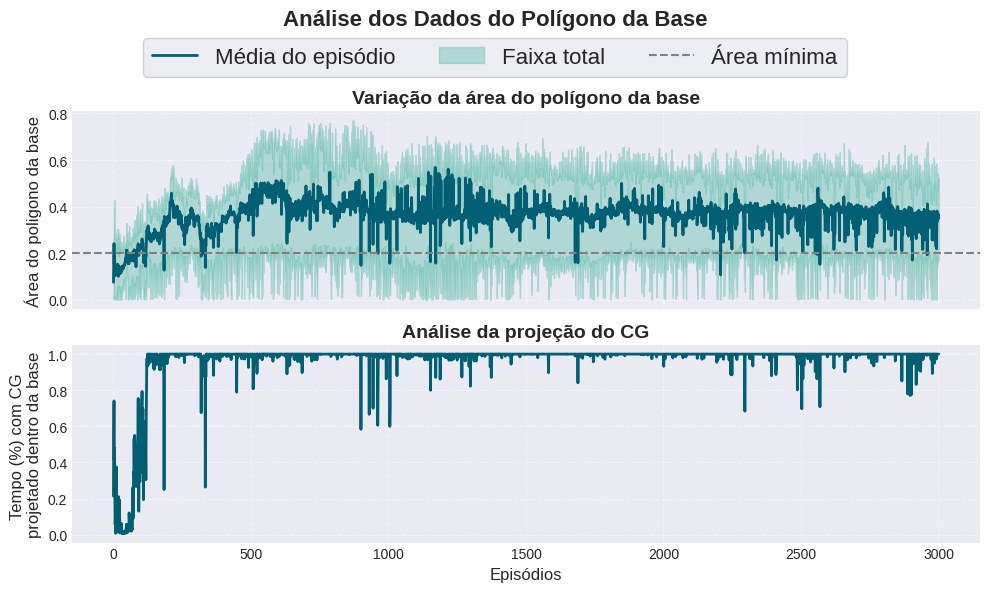

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE), sharex=True)

def plot_subplot(ax, mean):
    ax.plot(steps, mean, color=MAIN_LINE_COLOR, linewidth=2, label = 'Média do episódio')
    
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

# Subplot 1: vx
plot_subplot(ax1, poligon_area.get_mean_list())
ax1.fill_between(steps, poligon_area.get_mins_list(), poligon_area.get_maxs_list(), color=MAIN_FILL_COLOR, alpha=0.3, label='Faixa total')
ax1.set_title("Variação da área do polígono da base", fontsize=14, fontweight='bold')
ax1.axhline(0.2, linestyle='--', color='gray', linewidth=1.5, label='Área mínima')
ax1.set_ylabel(f'Área do poligono da base', fontsize=12)

# Subplot 2: vy
plot_subplot(ax2, cg_inside.get_mean_list())
ax2.set_title("Análise da projeção do CG", fontsize=14, fontweight='bold')
ax2.set_xlabel('Episódios', fontsize=12)
ax2.set_ylabel(f'Tempo (%) com CG \nprojetado dentro da base', fontsize=12)


# Título geral
fig.suptitle('Análise dos Dados do Polígono da Base', fontsize=16, fontweight='bold')
handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=LEGEND_SIZE, frameon=True, framealpha=0.9,bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.93])

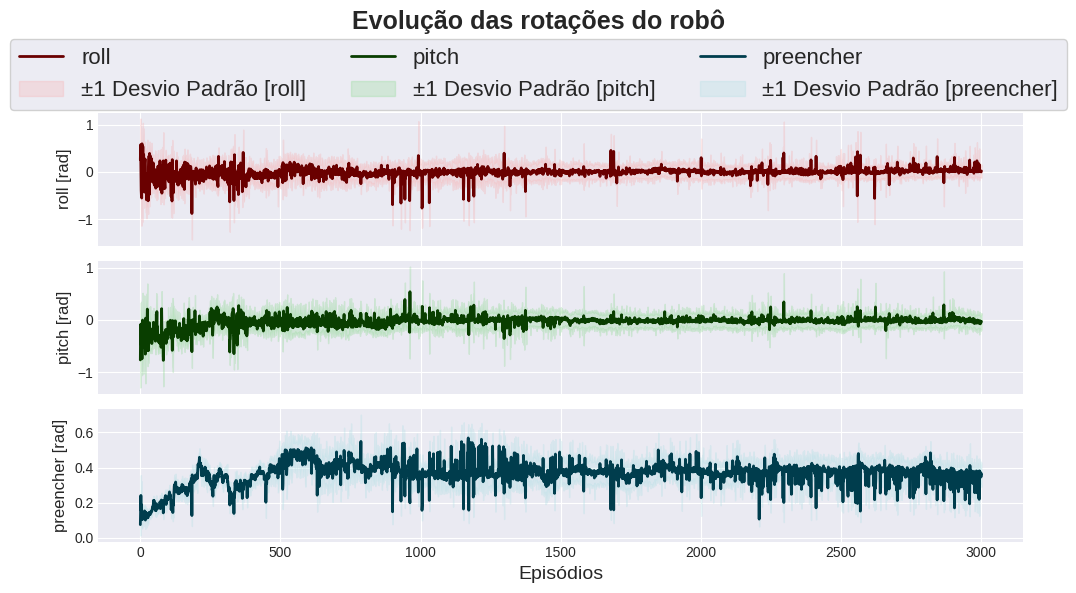

In [39]:

fig, axs = plt.subplots(3, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE), sharex=True)

def plot_subplot(ax, mean, mins, maxs, color_line, color_fill, label):
    ax.plot(mean, color=color_line, label=label, linewidth=2)
    ax.fill_between(range(len(mean)), mins, maxs, color=color_fill, alpha=0.25,label = f'±1 Desvio Padrão [{label}]')
    ax.set_ylabel(f'{label} [rad]', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

# Subplot 1: vx
plot_subplot(axs[0], roll.get_mean_list(),
             roll.get_mean_list() - roll.get_std_deviation_step(),
             roll.get_mean_list() + roll.get_std_deviation_step(),
             RED_LINE_COLOR, RED_FILL_COLOR, 'roll')

# Subplot 2: vy
plot_subplot(axs[1], pitch.get_mean_list(),
             pitch.get_mean_list() - pitch.get_std_deviation_step(),
             pitch.get_mean_list() + pitch.get_std_deviation_step(),
             GREEN_LINE_COLOR, GREEN_FILL_COLOR, 'pitch')

# Subplot 2: vy
plot_subplot(axs[2], correct_direction.get_mean_list(),
             correct_direction.get_mean_list() - correct_direction.get_std_deviation_step(),
             correct_direction.get_mean_list() + correct_direction.get_std_deviation_step(),
             BLUE_LINE_COLOR, BLUE_FILL_COLOR, 'preencher')

# Pega legendas separadamente e junta
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()
handles2, labels2 = axs[2].get_legend_handles_labels()

handles = handles0 + handles1 + handles2
labels = labels0 + labels1 + labels2

# Legenda geral no topo
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=LEGEND_SIZE,
           frameon=True, framealpha=0.9, bbox_to_anchor=(0.5, 0.95))

axs[2].set_xlabel('Episódios', fontsize=14)
fig.suptitle('Evolução das rotações do robô', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()



### Direção correta

### Velocidades vx,vy e vz

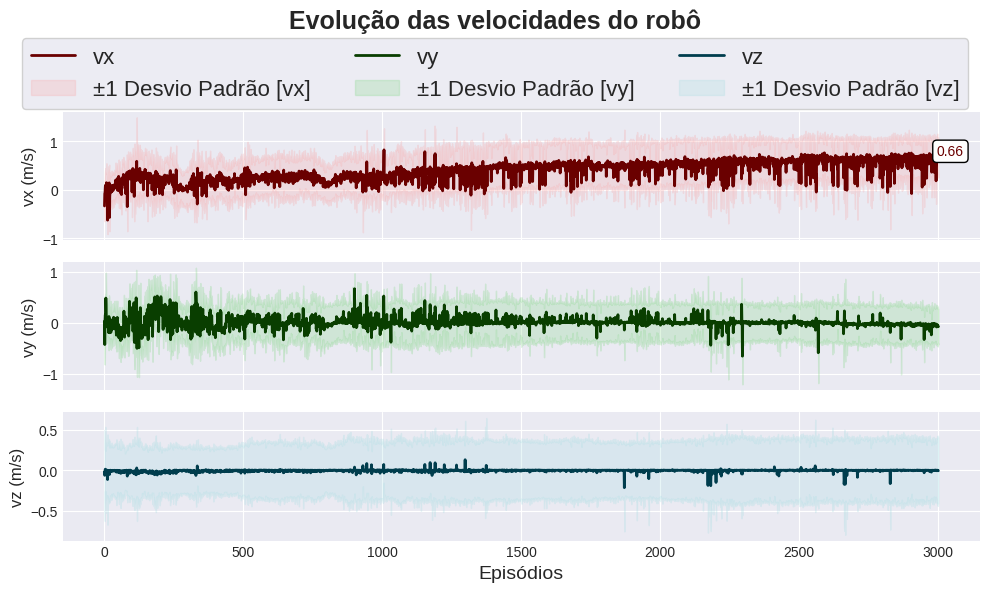

In [46]:

fig, axs = plt.subplots(3, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE), sharex=True)

def plot_subplot(ax, mean, mins, maxs, color_line, color_fill, label):
    ax.plot(mean, color=color_line, label=label, linewidth=2)
    ax.fill_between(range(len(mean)), mins, maxs, color=color_fill, alpha=0.25,label = f'±1 Desvio Padrão [{label}]')
    ax.set_ylabel(f'{label} (m/s)', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

    if label == 'vx':
        final_value = mean[-1]
        final_index = len(mean) - 1
        ax.annotate(f'{final_value:.2f}', 
                    xy=(final_index, final_value), 
                    xytext=(final_index - 5, final_value + 0.05),
                    fontsize=10, color=color_line,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=1),
                    arrowprops=dict(arrowstyle='->', color=color_line))

# Subplot 1: vx
plot_subplot(axs[0], vx.get_mean_list(),
             vx.get_mean_list() - vx.get_std_deviation_step(),
             vx.get_mean_list() + vx.get_std_deviation_step(),
             '#6a0000', '#f9a6a6', 'vx')

# Subplot 2: vy
plot_subplot(axs[1], vy.get_mean_list(),
             vy.get_mean_list() - vy.get_std_deviation_step(),
             vy.get_mean_list() + vy.get_std_deviation_step(),
             '#093e00', '#81d784', 'vy')

# Subplot 3: vz
plot_subplot(axs[2], vz.get_mean_list(),
             vz.get_mean_list() - vz.get_std_deviation_step(),
             vz.get_mean_list() + vz.get_std_deviation_step(),
             '#003d4d', '#a6dee3', 'vz')

# Pega legendas separadamente e junta
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()
handles2, labels2 = axs[2].get_legend_handles_labels()

handles = handles0 + handles1 + handles2
labels = labels0 + labels1 + labels2

# Legenda geral no topo
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=LEGEND_SIZE,
           frameon=True, framealpha=0.9, bbox_to_anchor=(0.5, 0.95))

axs[2].set_xlabel('Episódios', fontsize=14)
fig.suptitle('Evolução das velocidades do robô', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()



### Avaliação de altura

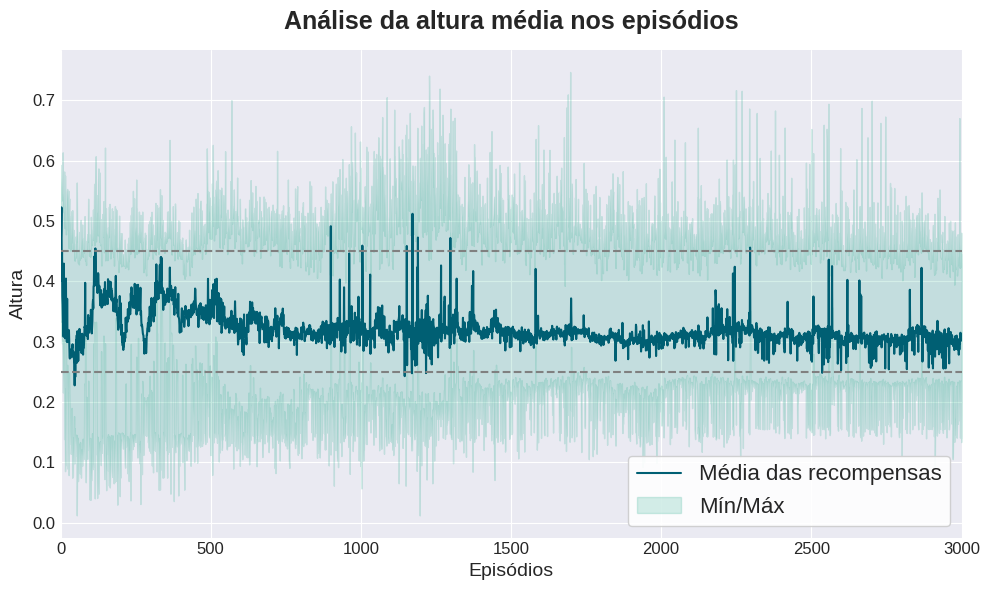

In [44]:
fig, ax = plt.subplots(figsize=(FIG_X_SIZE, FIG_Y_SIZE))
plt.plot(range(len(z.get_mean_list())), z.get_mean_list(), label='Média das recompensas', color=MAIN_LINE_COLOR)
plt.fill_between(range(len(z.get_mean_list())), z.get_mins_list(), z.get_maxs_list(), color=MAIN_FILL_COLOR, alpha=0.2, label='Mín/Máx')
ax.hlines([0.25, 0.45], xmin=0, xmax=4000, colors='gray', linestyles='--')
ax.set_xlim([0,3000])
ax.set_title('Análise da altura média nos episódios', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Episódios', fontsize=14)
ax.set_ylabel('Altura', fontsize=14)
ax.legend(loc='lower right', fontsize=16, frameon=True, framealpha=0.9, facecolor='white')
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()